In [1]:
import kagglehub
orvile_pmram_bangladeshi_brain_cancer_mri_dataset_path = kagglehub.dataset_download('orvile/pmram-bangladeshi-brain-cancer-mri-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'pmram-bangladeshi-brain-cancer-mri-dataset' dataset.
Data source import complete.


# Step 1: Setting Up the Environment

First, we import all the necessary libraries. We primarily use TensorFlow and its high-level API, Keras, to build and train our model. We also use Matplotlib for visualizing our data and results.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Step 2: Loading and Preparing the Data



In [3]:
import os

# --- 1. Define Constants ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Construct DATASET_PATH using the downloaded path from kagglehub
# and the specific subdirectories for the Augmented data.
DATASET_PATH = os.path.join(orvile_pmram_bangladeshi_brain_cancer_mri_dataset_path, "PMRAM Bangladeshi Brain Cancer - MRI Dataset", "PMRAM Bangladeshi Brain Cancer - MRI Dataset", "Augmented Data", "Augmented")

class_names = ['512Glioma', '512Meningioma', '512Normal', '512Pituitary'] # Adjusted to match expected output

# --- 2. Load the Data ---
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# --- 3. Create a Data Augmentation Layer ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
])

# --- 4. Configure the Datasets for Performance ---
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 6004 files belonging to 4 classes.
Using 4804 files for training.
Found 6004 files belonging to 4 classes.
Using 1200 files for validation.


# Step 3: Visualizing the Data



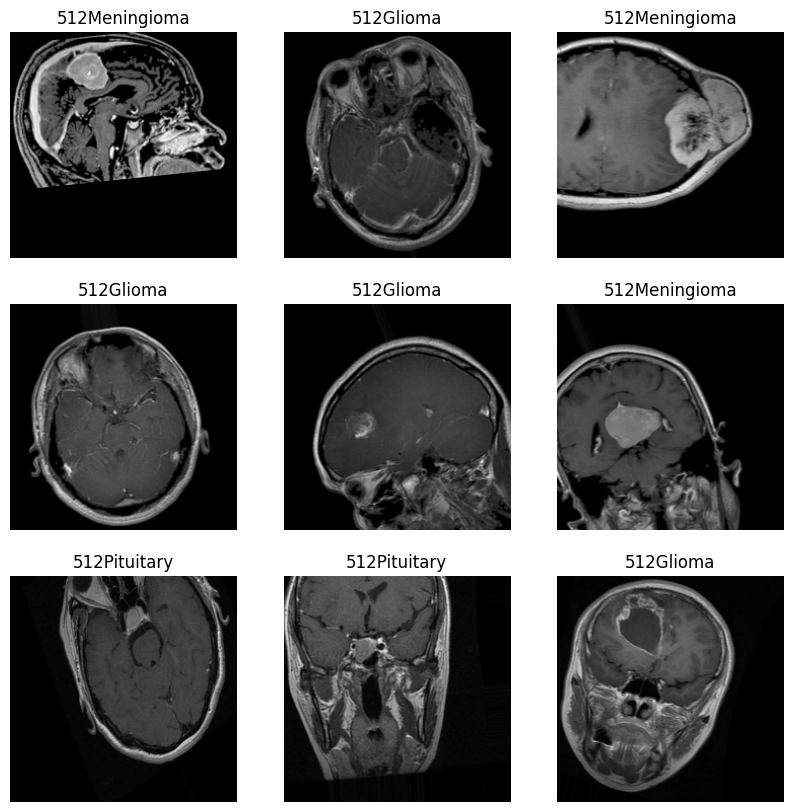

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Step 4: Building the Model with Transfer Learning

We use a powerful technique called transfer learning. Instead of building a model from scratch, we use a pre-trained model, EfficientNetB0, that has already learned to recognize features from millions of images from the ImageNet dataset.

We load EfficientNetB0 without its final classification layer (include_top=False) and "freeze" its weights so they won't be updated during training. Then, we add our own custom layers on top:


In [5]:
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras import models

# --- 1. Load the Pre-trained Base Model ---
base_model = EfficientNetB0(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')
base_model.trainable = False

# --- 2. Create the New Model by Adding Our Layers ---
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = models.Model(inputs, outputs)

# --- 3. Print a Summary of the Model ---
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Step 5: Compiling and Training the Model 🚀


In [6]:
# --- 1. Compile the Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 2. Set Up Callbacks ---
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# --- 3. Train the Model ---
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

print("\nTraining finished!")

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.5212 - loss: 1.0912 - val_accuracy: 0.8058 - val_loss: 0.5516
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.7805 - loss: 0.6177 - val_accuracy: 0.8242 - val_loss: 0.4473
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.8132 - loss: 0.5087 - val_accuracy: 0.8367 - val_loss: 0.4114
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.8236 - loss: 0.4779 - val_accuracy: 0.8583 - val_loss: 0.3751
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.8310 - loss: 0.4507 - val_accuracy: 0.8608 - val_loss: 0.3642
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.8435 - loss: 0.4333 - val_accuracy: 0.8475 - val_loss: 0.3593
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8421 - loss: 0.4281 - val_accuracy: 0.8533 - val_loss: 0.3494
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.8651 - loss: 0.3962 -

# Step 6: Evaluating Model Performance 📊


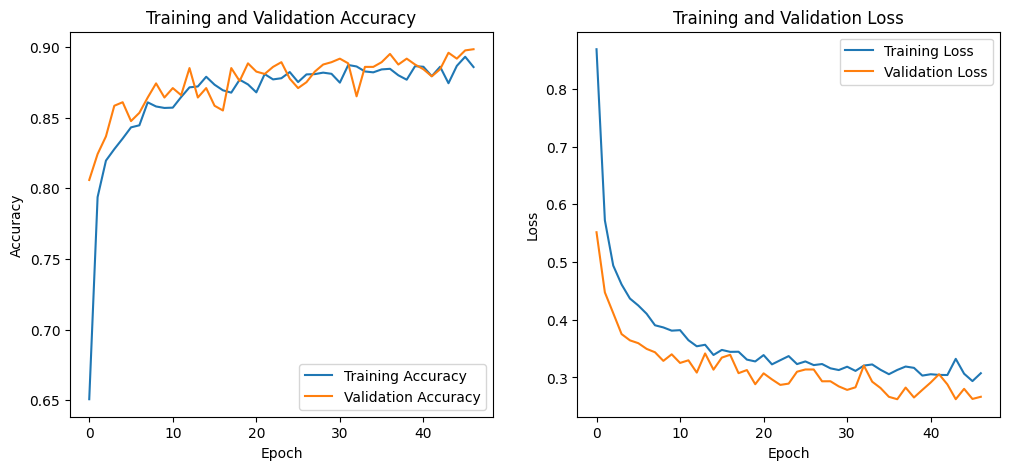


Classification Report:
               precision    recall  f1-score   support

    512Glioma       0.84      0.86      0.85       266
512Meningioma       0.87      0.81      0.84       316
    512Normal       0.97      0.91      0.94       311
 512Pituitary       0.89      1.00      0.94       307

     accuracy                           0.90      1200
    macro avg       0.89      0.89      0.89      1200
 weighted avg       0.90      0.90      0.89      1200



In [7]:
# --- 1. Plot Training History ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# --- 2. Generate Classification Report ---
y_pred = []
y_true = []
for image_batch, label_batch in validation_dataset:
   y_true.extend(label_batch.numpy())
   preds = model.predict(image_batch, verbose=0)
   y_pred.extend(np.argmax(preds, axis=-1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))